## Luminosity comparison

In [2]:
from import_data import HMXB_parameters_Kaper
from import_data import HMXB_parameters
from import_data import supergiant_stellar_parameters
from import_data import falenga

from astropy.constants import R_sun, L_sun, sigma_sb

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Import data
df_hmxb = HMXB_parameters()
df_sg_params = supergiant_stellar_parameters()
df_falenga = falenga()

df_luminosity = pd.DataFrame({'id': df_hmxb['id'].copy(),
                              "L_phot": [None] * len(df_hmxb['id']),
                              "L_spec": [None] * len(df_hmxb['id'])})

Calculate the luminosity from photometric data

In [4]:
for i in range(df_hmxb.shape[0]):
    # Calculate extinction
    Av = 3.2 * (df_hmxb.loc[i, '(B-V)obs'] - df_hmxb.loc[i, '(B-V)0'])

    # Calculate Absulute magnitude (visual)
    Mv = df_hmxb.loc[i, 'mv'] - 5 * np.log10(df_hmxb.loc[i, 'distance'] * 1000) + 5 - Av

    # Calculate bolomatric absolute magnitude
    Mbol = Mv + df_hmxb.loc[i, 'BC']

    # Calculate the luminosity in solar luminosities
    L = 10**((Mbol - 4.74) / (-2.5))

    # Put L in luminosity dataframe
    df_luminosity.loc[df_luminosity["id"] == df_hmxb.loc[i, 'id'], "L_phot"] = L
    # Put L in the dataframe
    df_hmxb.loc[i, 'luminosity'] = L


Caclulate the luminosity from the radius and temperature of the optical star

In [5]:
for i in range(df_falenga.shape[0]):
    # Orbital separation
    a = df_falenga.loc[i, 'a'] * R_sun.value
    # Inclination
    inc = df_falenga.loc[i, 'i']
    # Semi eclipse angle
    theta_e = df_falenga.loc[i, 'semi_eclipse_angle']


    # Calculate Radius
    Rob = a * ((np.cos(np.deg2rad(inc)))**2 + (np.sin(np.deg2rad(inc)))**2 * (np.sin(np.deg2rad(theta_e)))**2)**(1/2)

    # Object id
    id = df_falenga.loc[i, 'id']
    # Spectral type
    spectral_type = df_hmxb[df_hmxb["id"] == str(id)]["spectraltype(short)"].reset_index(drop=True).at[0]
    # Spectral temperature
    logTeff = df_sg_params[df_sg_params["sp"] == spectral_type]["logTeff"].reset_index(drop=True).at[0]
    Teff = 10**logTeff

    # Calculate Luminosity in solar luminosities
    L = (4 * np.pi * Rob**2 * sigma_sb.value * Teff**4) / L_sun.value

    # Put L in luminosity dataframe
    df_luminosity.loc[df_luminosity["id"] == id, "L_spec"] = L

In [6]:
df_luminosity.style

,id,L_phot,L_spec
0,2S0114+650,49208.616723,None
1,SMC X-1,7299018.611203,268315.729926
2,LMC X-4,3765078.649906,79108.613443
3,Vela X-1,849995.209055,471774.072060
4,Cen X-3,11264879.332612,148536.682414
5,GX301-2,1568789.081906,None
6,4U1538-52,523184.997756,52119.016724
7,4U1700-37,775452.321506,1121027.220198
8,4U1907+09,1742107.551680,None
9,LMC X-1,201304.410650,None


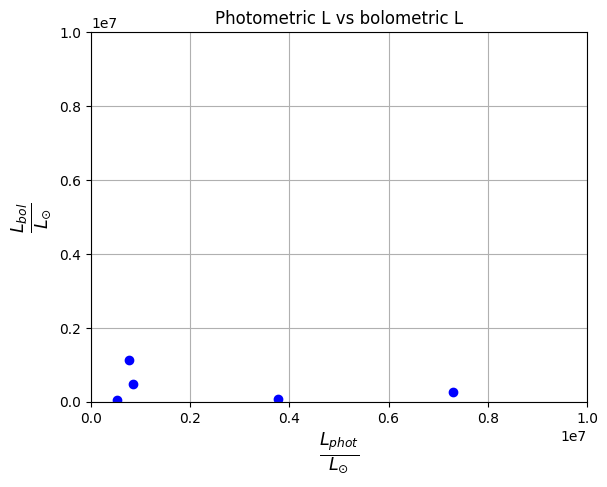

In [24]:
filtered_df = df_luminosity.dropna(subset=["L_phot", "L_spec"])

# Create a scatter plot of L1 vs. L2
plt.scatter(filtered_df["L_phot"], filtered_df["L_spec"], color='blue')
plt.grid(True)
plt.xlabel(r"$\frac{L_{phot}}{L_{\odot}}$", fontsize=18)
plt.ylabel(r"$\frac{L_{bol}}{L_{\odot}}$", fontsize=18)
plt.xlim(0, 10**7)
plt.ylim(0, 10**7)
plt.title("Photometric L vs bolometric L")
plt.savefig("/mnt/c/Users/luukv/OneDrive/Masterproject/plots/UnderluminousScatter.png")
plt.show()

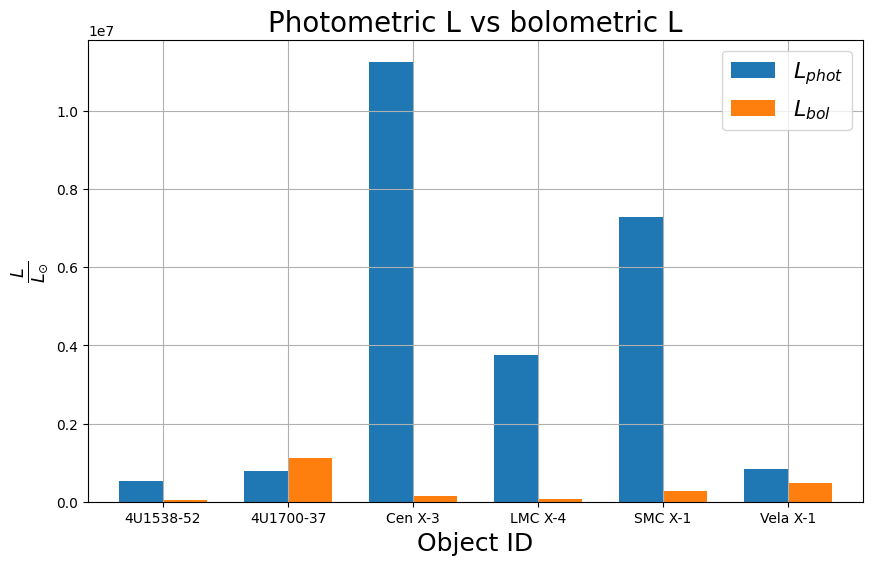

In [25]:
# Group the DataFrame by "id" and calculate the sum of "L1" and "L2" for each group
grouped = filtered_df.groupby("id")[["L_phot", "L_spec"]].sum()

# Plot the bar chart
grouped.plot(kind="bar", width=0.7, figsize=(10, 6))
plt.grid(True)
plt.xlabel("Object ID", fontsize=18)
plt.ylabel(r"$\frac{L}{L_{\odot}}$", fontsize=18)
plt.title("Photometric L vs bolometric L", fontsize=20)
plt.legend([r"$L_{phot}$", r"$L_{bol}$"], fontsize=16)
plt.xticks(rotation=0)  # Optional: Rotate x-axis labels if needed
plt.savefig("/mnt/c/Users/luukv/OneDrive/Masterproject/plots/UnderluminousBar.png")
plt.show()